In [1]:
import numpy as np
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time


In [2]:

# Generate synthetic regression data
# N_SAMPLES - number of samples (rows)
# N_FEATURES - number of featues (columns)
# N_INFORMATIVE - number of features related to the target 
# - The rest are random noise
N_SAMPLES = 1_000_000
N_FEATURES = 100
N_INFORMATIVE = 10
X, y = make_regression(
    n_samples=N_SAMPLES,
    n_features=N_FEATURES,
    n_informative=N_INFORMATIVE,
    random_state=42  # for reproducibility
)

# Convert to DataFrame for better readability
feature_names = [f'feature_{i}' for i in range(1, N_FEATURES + 1)]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Add fold column using KFold
kf = KFold(n_splits=4, shuffle=True, random_state=42)
df['fold_id'] = -1  # Initialize with -1

# Assign fold IDs (0, 1, 2, 3) to each row
for fold_id, (_, test_idx) in enumerate(kf.split(df)):
    df.loc[test_idx, 'fold_id'] = fold_id

# Convert fold_id to integer
df['fold_id'] = df['fold_id'].astype(int)

# Save to CSV
# df.to_csv('/home/jovyan/data/synthetic_regression_data.csv', index=False)

print(f"Synthetic dataset created with shape: {df.shape}")
print(f"Sample data:")
print(df.head())
print(f"Data summary:")
print(df.describe())

# Verify fold distribution
print("\nFold distribution:")
print(df['fold_id'].value_counts().sort_index())

Synthetic dataset created with shape: (1000000, 102)
Sample data:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.608307   1.650697  -0.320632  -0.790054   0.025639  -1.368853   
1   0.472118  -1.504947  -3.109209  -0.163493   0.475398  -0.096523   
2  -0.683083  -0.679245   0.654722  -1.920132  -0.681558  -0.059824   
3  -0.631536   1.250956  -0.863528   0.496616  -0.379724  -1.368657   
4   1.973148  -0.661721  -0.562188   0.195168   0.981961   1.268245   

   feature_7  feature_8  feature_9  feature_10  ...  feature_93  feature_94  \
0   0.984844  -0.355361  -0.131309   -1.313255  ...    0.608165    1.816227   
1   0.089983  -2.047795   0.589673   -1.128312  ...    0.040350   -0.017446   
2   1.324597   0.522427   2.628749    1.121996  ...    0.410474    0.352845   
3  -1.097906   0.744126   0.375609    1.424055  ...    0.547961    1.515363   
4  -1.326135  -0.454399   2.363024   -0.036983  ...    1.123105   -0.830542   

   feature_95  feature_96  featu

Dataset loaded with shape: (1000000, 102)

----- Fold 0 -----
Training on 750000 samples, testing on 250000 samples
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 100
[LightGBM] [Info] Start training from score 0.366776
Fold 0: Training time: 20.8857 seconds
RMSE: 11.9300
R² Score: 0.9956

----- Fold 1 -----
Training on 750000 samples, testing on 250000 samples
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 100
[LightGBM] [Info] Start training from score 0.093960
Fold 1: Training time: 21.7614 seconds
RMSE: 12.03

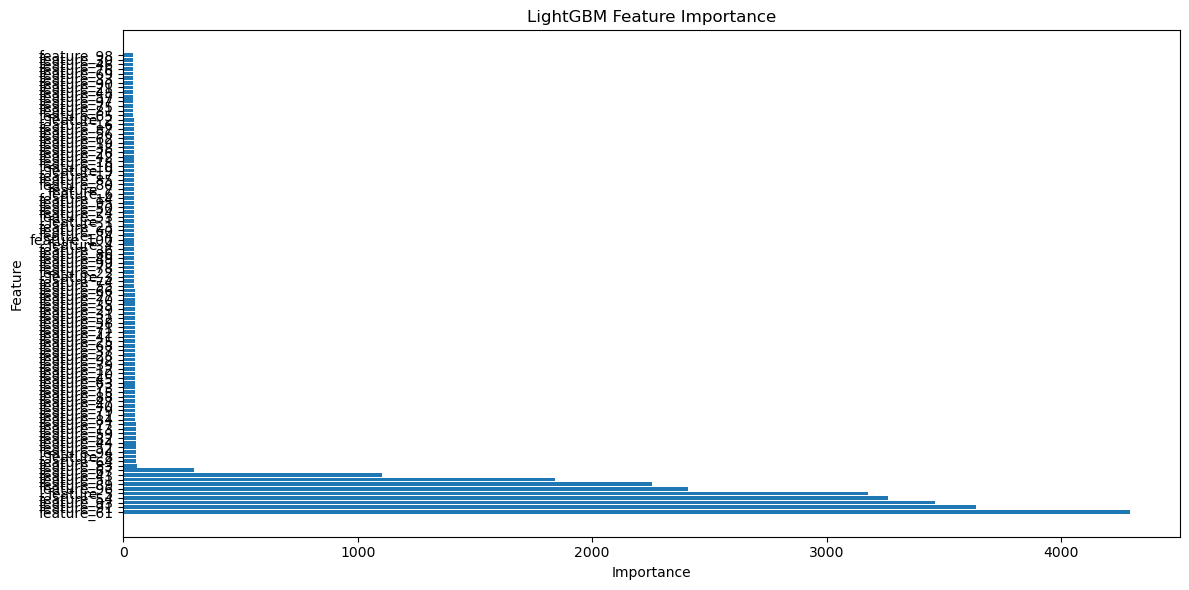

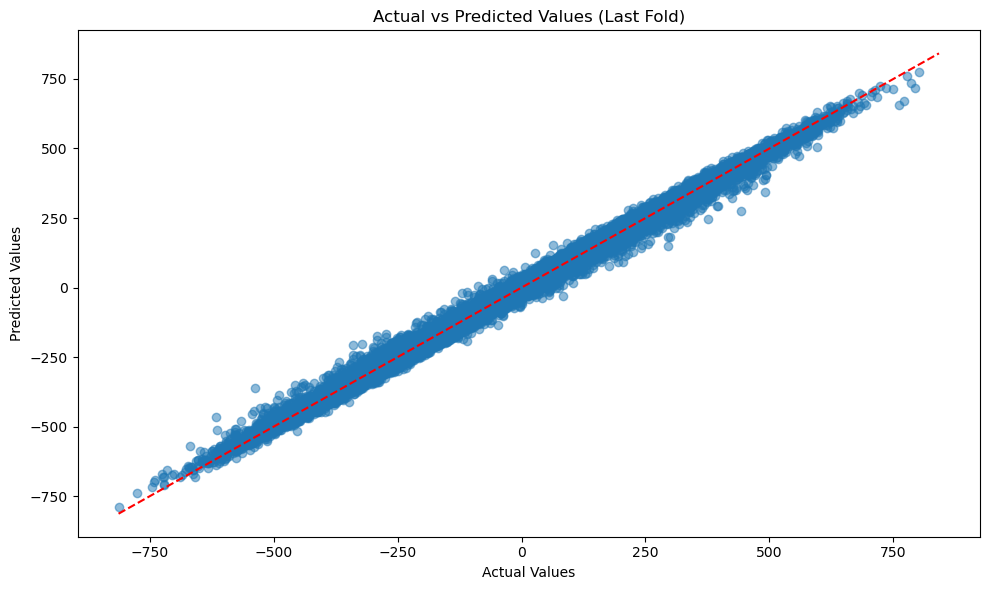

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 1000000, number of used features: 100
[LightGBM] [Info] Start training from score 0.183312

Final model trained on entire dataset
Top 10 important features: ['feature_61', 'feature_91', 'feature_93', 'feature_54', 'feature_5', 'feature_96', 'feature_89', 'feature_51', 'feature_43', 'feature_67']

Recall: The synthetic dataset was created with 10 informative features out of 100.


In [6]:

# Load the synthetic dataset
# df = pd.read_csv('/home/jovyan/data/synthetic_regression_data.csv')

print(f"Dataset loaded with shape: {df.shape}")

# Separate features and target
X = df.drop(['target', 'fold_id'], axis=1)
y = df['target']

# Initialize lists to store performance metrics
rmse_scores = []
r2_scores = []
feature_importances = []

# Train and evaluate on each fold
for fold in range(4):
    print(f"\n----- Fold {fold} -----")
    
    # Get train/test indices for this fold
    train_idx = df[df['fold_id'] != fold].index
    test_idx = df[df['fold_id'] == fold].index
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
    
    # Initialize and train the model
    model = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.1,
        max_depth=7,
        num_leaves=31,
        n_jobs=-1,
        random_state=42
    )
    
    # get start time for timing
    start_time = time.perf_counter()
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        # early_stopping_rounds=20,
        # verbose=25
    )
    # get end time for timing
    end_time = time.perf_counter()
    print(f"Fold {fold}: Training time: {end_time - start_time:.4f} seconds")
# 
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Store metrics
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    feature_importances.append(model.feature_importances_)

# Calculate average metrics
print("\n----- Cross-Validation Results -----")
print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Average R² Score: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# Calculate and plot average feature importance
avg_feature_importance = np.mean(feature_importances, axis=0)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': avg_feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values for the last fold
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Last Fold)')
plt.tight_layout()
plt.show()

# Train a final model on the entire dataset
final_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7, 
    num_leaves=31,
    random_state=42
)

final_model.fit(X, y)

print("\nFinal model trained on entire dataset")
print(f"Top 10 important features: {feature_importance_df['Feature'].head(10).tolist()}")

# Remember we created this with only 10 informative features out of 20
print(f"\nRecall: The synthetic dataset was created with {N_INFORMATIVE} informative features out of {N_FEATURES}.")